In [2]:
import pandas as pd
import subprocess
import os
import re
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import itertools


In [26]:
directory = "/rna/myk/analysis/class/guided_mission_bio/Termproj_final/CLIP_pileup_depth"
chromosomes = list(map(str, range(1, 20))) + ['X', 'Y']
pileup_data = {}

for chr in chromosomes:
    file_path = os.path.join(directory, f"CLIP-chr{chr}_depth.pileup")
    try:
        df = pd.read_csv(file_path, sep='\t', names=['chrom', 'pos', 'ref', 'count', 'basereads', 'quals'])
        pileup_data[f"chr{chr}"] = df
    except FileNotFoundError:
        print(f"File not found: {file_path}")


In [27]:
tokeep = re.compile('[^AGCTagct]')
for chr_key in pileup_data.keys():
    pileup_data[chr_key]['matches'] = pileup_data[chr_key]['basereads'].apply(lambda x: tokeep.sub('', x))

In [28]:
pileup_new = {}

for chr_key in pileup_data.keys():
    pileup_new[chr_key] = pileup_data[chr_key][['chrom', 'pos', 'matches']]
    pileup_new[chr_key]['matches'] = pileup_new[chr_key]['matches'].str.upper()

/tmp/ipykernel_4179691/1052848703.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pileup_new[chr_key]['matches'] = pileup_new[chr_key]['matches'].str.upper()
/tmp/ipykernel_4179691/1052848703.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pileup_new[chr_key]['matches'] = pileup_new[chr_key]['matches'].str.upper()
/tmp/ipykernel_4179691/1052848703.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [29]:
for chr_key in pileup_data.keys():
    pileup_new[chr_key] = pileup_new[chr_key][pileup_new[chr_key]['matches'].str.len() > 5]

In [30]:
def calculate_shannon_entropy(base_counts):
    total = sum(base_counts.values())
    entropy = 0
    for count in base_counts.values():
        if count > 0:
            p = count / total
            entropy -= p * np.log2(p)
    return entropy



for chr_key in pileup_data.keys():
    entropies = []
    for index, row in pileup_new[chr_key].iterrows():
        base_counts = Counter(row['matches'])
        entropy = calculate_shannon_entropy(base_counts)
        entropies.append(entropy)
    pileup_new[chr_key]['shannon_entropy'] = entropies

In [31]:
shannon_entropy_values = []
for chr_key in pileup_data.keys():
    shannon_entropy_values += pileup_new[chr_key]['shannon_entropy'].tolist()

(array([1.2507986e+07, 6.8772000e+04, 6.8661000e+04, 6.5227000e+04,
        6.8748000e+04, 6.2230000e+04, 5.9092000e+04, 6.6503000e+04,
        6.0497000e+04, 4.6816000e+04, 6.3590000e+04, 5.2608000e+04,
        3.3139000e+04, 5.6977000e+04, 3.7317000e+04, 3.1675000e+04,
        3.7302000e+04, 3.4334000e+04, 3.5435000e+04, 5.4099000e+04,
        1.1518000e+04, 3.8600000e+03, 3.6440000e+03, 3.6310000e+03,
        3.5130000e+03, 3.7800000e+03, 3.2620000e+03, 3.3780000e+03,
        3.2490000e+03, 3.1910000e+03, 3.1760000e+03, 2.1700000e+03,
        4.3900000e+02, 3.4900000e+02, 3.4300000e+02, 2.4500000e+02,
        1.9300000e+02, 1.4900000e+02, 1.2900000e+02, 6.5000000e+01]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  ]),
 <BarContainer object of 40 artists>)

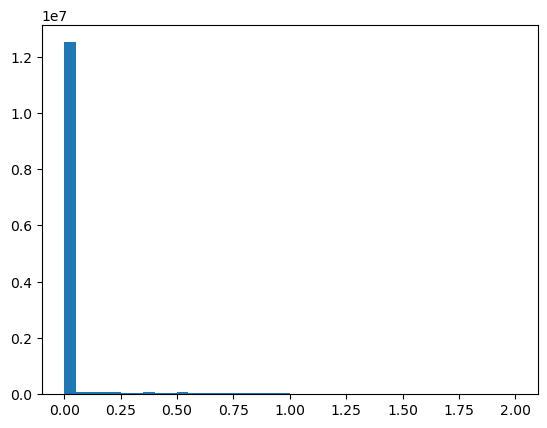

In [32]:
plt.hist(shannon_entropy_values, bins=40)
#plt.xlim(0.2,2)
#plt.ylim(0, 100000)

0.039464341852265446
0.0


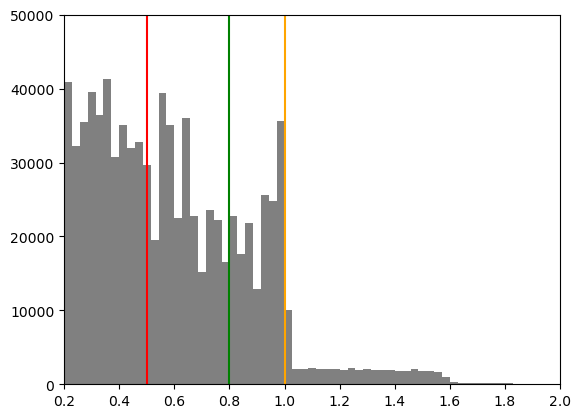

In [33]:
plt.hist(shannon_entropy_values, bins=70, color = 'grey')
plt.xlim(0.2,2)
plt.ylim(0, 50000)
plt.axvline(0.5, c='red')
plt.axvline(0.8, c='green')
plt.axvline(1, c='orange')
print(np.mean(shannon_entropy_values))
print(np.median(shannon_entropy_values))

In [34]:
count_greater_than_05 = sum(1 for x in shannon_entropy_values if x > 0.5)
count_greater_than_08 = sum(1 for x in shannon_entropy_values if x > 0.8)
count_greater_than_1 = sum(1 for x in shannon_entropy_values if x > 1)
count_all = len(shannon_entropy_values)
print(count_greater_than_05)
print(count_greater_than_08)
print(count_greater_than_1)
print(count_all)
print(count_greater_than_05 / count_all)
print(count_greater_than_08 / count_all)
print(count_greater_than_1 / count_all)

486760
211454
42167
13561292
0.03589333523679012
0.015592467148410344
0.003109364505977749


In [35]:
pileup_shn_04 = {}

for chr_key in pileup_data.keys():
    pileup_shn_04[chr_key] = pileup_new[chr_key][pileup_new[chr_key]['shannon_entropy'] > 0.4]

In [36]:
pileup_shn = pd.concat([pileup_shn_04[f'chr{i}'] for i in range(1, 20)] + [pileup_shn_04['chrX'], pileup_shn_04['chrY']])
pileup_shn

,chrom,pos,matches,shannon_entropy
29,chr1,3142517,GAGAAAAAAAAAA,0.619382
129,chr1,3221478,GGGAGGGAAGGGGG,0.749595
135,chr1,3221484,AAAAGAAAGGAAAAA,0.721928
153,chr1,3221575,GGGTTTCCCCCCC,1.457266
167,chr1,3221729,GGAGAAAGGGGGAA,0.985228
...,...,...,...,...
343437,chrY,90837748,AAAAAAATTTA,0.845351
343488,chrY,90837849,AAAAAAAAGGGGGGGGGGGGGGGG,0.918296
343491,chrY,90837852,AAAAAAAAAAAAAAAAAAAAAACC,0.413817
343511,chrY,90839087,GGGGGGGGGGAAAGGGG,0.672295


In [37]:
pileup_shn['start'] = pileup_shn['pos'] - 6
pileup_shn['end'] = pileup_shn['pos'] + 5
pileup_shn

,chrom,pos,matches,shannon_entropy,start,end
29,chr1,3142517,GAGAAAAAAAAAA,0.619382,3142511,3142522
129,chr1,3221478,GGGAGGGAAGGGGG,0.749595,3221472,3221483
135,chr1,3221484,AAAAGAAAGGAAAAA,0.721928,3221478,3221489
153,chr1,3221575,GGGTTTCCCCCCC,1.457266,3221569,3221580
167,chr1,3221729,GGAGAAAGGGGGAA,0.985228,3221723,3221734
...,...,...,...,...,...,...
343437,chrY,90837748,AAAAAAATTTA,0.845351,90837742,90837753
343488,chrY,90837849,AAAAAAAAGGGGGGGGGGGGGGGG,0.918296,90837843,90837854
343491,chrY,90837852,AAAAAAAAAAAAAAAAAAAAAACC,0.413817,90837846,90837857
343511,chrY,90839087,GGGGGGGGGGAAAGGGG,0.672295,90839081,90839092


In [50]:
pileup_shn_depth = pileup_shn[pileup_shn['matches'].str.len() > 5]
pileup_shn_depth

,chrom,pos,matches,shannon_entropy,start,end
29,chr1,3142517,GAGAAAAAAAAAA,0.619382,3142511,3142522
129,chr1,3221478,GGGAGGGAAGGGGG,0.749595,3221472,3221483
135,chr1,3221484,AAAAGAAAGGAAAAA,0.721928,3221478,3221489
153,chr1,3221575,GGGTTTCCCCCCC,1.457266,3221569,3221580
167,chr1,3221729,GGAGAAAGGGGGAA,0.985228,3221723,3221734
...,...,...,...,...,...,...
343437,chrY,90837748,AAAAAAATTTA,0.845351,90837742,90837753
343488,chrY,90837849,AAAAAAAAGGGGGGGGGGGGGGGG,0.918296,90837843,90837854
343491,chrY,90837852,AAAAAAAAAAAAAAAAAAAAAACC,0.413817,90837846,90837857
343511,chrY,90839087,GGGGGGGGGGAAAGGGG,0.672295,90839081,90839092


In [39]:
bedform = pileup_shn_depth[['chrom', 'start', 'end']]
bedform.to_csv('CLIP_mut_mild.bed', sep='\t', index=False, header=False)

In [40]:
!bedtools getfasta -fi /rna/myk/analysis/class/guided_mission_bio/Termproj_final/reference/GRCm39.genome.fa -bed CLIP_mut_mild.bed -fo CLIP_mut_mild.fasta

In [41]:
refneg = pd.read_csv("/rna/myk/analysis/class/guided_mission_bio/binfo1-datapack1/gencode_negstrand.gtf.bed", sep="\t", header=None)
refneg.columns = ["chrom", "start", "end"]
refneg = refneg[refneg["chrom"] != "chrM"]
refneg

,chrom,start,end
0,chr1,3276124,3741721
1,chr1,3435954,3438772
2,chr1,3445779,3448011
3,chr1,3535200,3537508
4,chr1,3582674,3584730
...,...,...,...
27575,chrY,90510316,90542914
27576,chrY,90614770,90617133
27577,chrY,90676615,90678894
27578,chrY,90763696,90766736


In [51]:
pileup_shn_depth['negativity'] = False
for index, row in pileup_shn_depth.iterrows():
    chromosome = row['chrom']
    position = row['pos']

    for _, ref_row in refneg[refneg['chrom'] == chromosome].iterrows():                                                                                                                
        if ref_row['start'] <= position <= ref_                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               row['end']:
            pileup_shn_depth.at[index, 'negativity'] = True
            break
                    

In [52]:
pileup_shn_depth['start'] = pileup_shn_depth['pos'] - 6             
pileup_shn_depth['end'] = pileup_shn_depth['pos'] + 5
pileup_shn_depth.to_csv('CLIP_pilup_shn_depth_mild.tsv', sep='\t', index=False)
pileup_shn_depth

,chrom,pos,matches,shannon_entropy,start,end,negativity
29,chr1,3142517,GAGAAAAAAAAAA,0.619382,3142511,3142522,True
129,chr1,3221478,GGGAGGGAAGGGGG,0.749595,3221472,3221483,False
135,chr1,3221484,AAAAGAAAGGAAAAA,0.721928,3221478,3221489,False
153,chr1,3221575,GGGTTTCCCCCCC,1.457266,3221569,3221580,False
167,chr1,3221729,GGAGAAAGGGGGAA,0.985228,3221723,3221734,False
...,...,...,...,...,...,...,...
343437,chrY,90837748,AAAAAAATTTA,0.845351,90837742,90837753,False
343488,chrY,90837849,AAAAAAAAGGGGGGGGGGGGGGGG,0.918296,90837843,90837854,False
343491,chrY,90837852,AAAAAAAAAAAAAAAAAAAAAACC,0.413817,90837846,90837857,False
343511,chrY,90839087,GGGGGGGGGGAAAGGGG,0.672295,90839081,90839092,False


In [53]:
pileup_shn_depth = pileup_shn_depth[pileup_shn_depth['matches'].str.len() > 5]
pileup_shn_depth

,chrom,pos,matches,shannon_entropy,start,end,negativity
29,chr1,3142517,GAGAAAAAAAAAA,0.619382,3142511,3142522,True
129,chr1,3221478,GGGAGGGAAGGGGG,0.749595,3221472,3221483,False
135,chr1,3221484,AAAAGAAAGGAAAAA,0.721928,3221478,3221489,False
153,chr1,3221575,GGGTTTCCCCCCC,1.457266,3221569,3221580,False
167,chr1,3221729,GGAGAAAGGGGGAA,0.985228,3221723,3221734,False
...,...,...,...,...,...,...,...
343437,chrY,90837748,AAAAAAATTTA,0.845351,90837742,90837753,False
343488,chrY,90837849,AAAAAAAAGGGGGGGGGGGGGGGG,0.918296,90837843,90837854,False
343491,chrY,90837852,AAAAAAAAAAAAAAAAAAAAAACC,0.413817,90837846,90837857,False
343511,chrY,90839087,GGGGGGGGGGAAAGGGG,0.672295,90839081,90839092,False


In [54]:
shn_pos = pileup_shn_depth[pileup_shn_depth['negativity'] == False]
shn_neg = pileup_shn_depth[pileup_shn_depth['negativity'] == True]

In [56]:
bedform_pos = shn_pos[['chrom', 'start', 'end']]
bedform_neg = shn_neg[['chrom', 'start', 'end']]
bedform_pos.to_csv('CLIP_mut_pos_mild.bed', sep='\t', index=False, header=False)
bedform_neg.to_csv('CLIP_mut_neg_mild.bed', sep='\t', index=False, header=False)

In [57]:
!bedtools getfasta -fi /rna/myk/analysis/class/guided_mission_bio/Termproj_final/reference/GRCm39.genome.fa -bed CLIP_mut_pos_mild.bed -fo CLIP_mut_pos_mild.fasta
!bedtools getfasta -fi /rna/myk/analysis/class/guided_mission_bio/Termproj_final/reference/GRCm39.genome.fa -bed CLIP_mut_neg_mild.bed -fo CLIP_mut_neg_mild.fasta

In [59]:
def reverse_complement(sequence):
    complement = str.maketrans('ATCG', 'TAGC')
    return sequence.translate(complement)[::-1]

def process_fasta(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        header = None
        sequence = []
        
        for line in infile:
            line = line.strip()
            if line.startswith('>'):
                if header is not None:
                    rev_comp_sequence = reverse_complement(''.join(sequence))
                    outfile.write(f"{header}\n{rev_comp_sequence}\n")
                
                header = line
                sequence = []
            else:
                sequence.append(line)
        
        if header is not None:
            rev_comp_sequence = reverse_complement(''.join(sequence))
            outfile.write(f"{header}\n{rev_comp_sequence}\n")


input_file = '/rna/myk/analysis/class/guided_mission_bio/Termproj_final/CLIP_mut_neg_mild.fasta'
output_file = '/rna/myk/analysis/class/guided_mission_bio/Termproj_final/CLIP_mut_neg_rev_mild.fasta'
process_fasta(input_file, output_file)

In [60]:
!less /rna/myk/analysis/class/guided_mission_bio/Termproj_final/CLIP_mut_neg_mild.fasta | wc -l
!less /rna/myk/analysis/class/guided_mission_bio/Termproj_final/CLIP_mut_neg_rev_mild.fasta | wc -l
!less /rna/myk/analysis/class/guided_mission_bio/Termproj_final/CLIP_mut_pos_mild.fasta | wc -l


596328
596328
591818


In [61]:
!cat /rna/myk/analysis/class/guided_mission_bio/Termproj_final/CLIP_mut_pos_mild.fasta /rna/myk/analysis/class/guided_mission_bio/Termproj_final/CLIP_mut_neg_rev_mild.fasta > /rna/myk/analysis/class/guided_mission_bio/Termproj_final/CLIP_mut_final_mild.fasta

In [62]:
!less /rna/myk/analysis/class/guided_mission_bio/Termproj_final/CLIP_mut_final_mild.fasta | wc -l

1188146


In [63]:
!awk 'NR % 2 == 0' /rna/myk/analysis/class/guided_mission_bio/Termproj_final/CLIP_mut_final_mild.fasta > /rna/myk/analysis/class/guided_mission_bio/Termproj_final/CLIP_mut_final_seq_mild.fasta

In [1]:
def convert_sequences_t_to_u(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            modified_line = line.replace('T', 'U')
            outfile.write(modified_line)


input_sequences = '/rna/myk/analysis/class/guided_mission_bio/Termproj_final/CLIP_mut_final_seq_mild.fasta'
output_sequences = '/rna/myk/analysis/class/guided_mission_bio/Termproj_final/CLIP_mut_final_seq_mild_TU.fasta'
convert_sequences_t_to_u(input_sequences, output_sequences)

In [3]:
def find_top_hexamers_with_ratios(sequences):
    hexamer_counts = Counter()
    
    for seq in sequences:
        if len(seq) == 11:
            for i in range(len(seq) - 5):
                hexamer = seq[i:i+6]
                hexamer_counts[hexamer] += 1

    total_counts = sum(hexamer_counts.values())
    hexamer_ratios = {hexamer: count / total_counts for hexamer, count in hexamer_counts.items()}
    most_common_hexamers = Counter(hexamer_ratios).most_common(10)
    return most_common_hexamers

In [4]:
def fasta_to_list(fasta_file):
    with open(fasta_file, 'r') as file:
        sequences = [line.strip() for line in file if line.strip()]
    return sequences

# Usage example:
fasta_file = '/rna/myk/analysis/class/guided_mission_bio/Termproj_final/CLIP_mut_final_seq_mild_TU.fasta'
sequences_list = fasta_to_list(fasta_file)
sequences_list[0:5]

['UAAAAGGAAUA', 'GAAUAGGCGGA', 'AGCAGGAGUAC', 'GCAAAGCCGAG', 'AGGCUGGGUCU']

In [5]:
top_hexamers = find_top_hexamers_with_ratios(sequences_list)
for hexamer, ratio in top_hexamers:
    print(f"Hexamer: {hexamer}, Ratio: {ratio:.4f}")


Hexamer: GAGGAG, Ratio: 0.0020
Hexamer: AGGAGA, Ratio: 0.0020
Hexamer: AAGGAG, Ratio: 0.0019
Hexamer: AGAAGA, Ratio: 0.0019
Hexamer: UGGAGA, Ratio: 0.0018
Hexamer: GAGAAG, Ratio: 0.0018
Hexamer: GAAGAG, Ratio: 0.0017
Hexamer: GGAGAA, Ratio: 0.0017
Hexamer: AGGAGG, Ratio: 0.0017
Hexamer: GGAGGA, Ratio: 0.0016


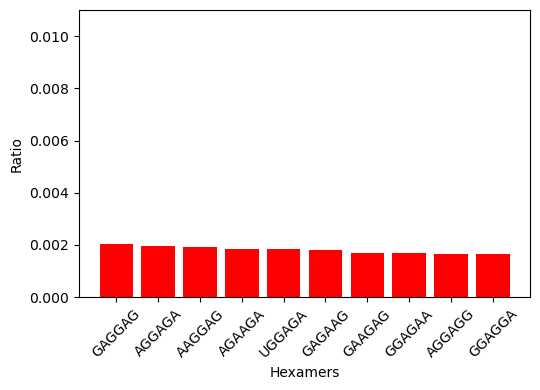

In [9]:
hexamers = [hexamer for hexamer, ratio in top_hexamers]
ratios = [ratio for hexamer, ratio in top_hexamers]

plt.figure(figsize=(5.5, 4))
plt.bar(hexamers, ratios, color='red')
plt.xlabel('Hexamers')
plt.ylabel('Ratio')
plt.ylim(0, 0.011)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()